In [1]:
import os.path as osp
import random
import sys

import geomstats.backend as gs
import geomstats.visualization as visualization
import matplotlib.pyplot as plt
import networkx as nx
import numpy
import numpy as np
import torch
import torch.nn.functional as F
import torch_geometric.datasets as ds
import torch_geometric.nn as nn
import torch_geometric.transforms as T
from geomstats.datasets import prepare_graph_data, utils
from geomstats.geometry.poincare_ball import PoincareBall, PoincareBallMetric
from gtda import diagrams, graphs, homology
from gtda.plotting import plot_diagram
from helper import *
from networkx.linalg.graphmatrix import adjacency_matrix
from plotly.offline import init_notebook_mode
from scipy.spatial.distance import pdist, squareform
from torch.nn import LeakyReLU, Linear, Parameter
from torch.nn import Sequential as seq
from torch.nn import init
from torch_geometric.data import Data, DataLoader, InMemoryDataset
from torch_geometric.nn import MessagePassing, global_add_pool
from torch_geometric.utils import to_networkx

# from torch_geometric.utils import (
#     add_self_loops,
#     remove_self_loops,
#     softmax,
#     to_undirected,
# )

INFO: Using numpy backend


In [ ]:
init_notebook_mode(connected=True)

In [2]:
class Graph:
    """Class for generating a graph object from a dataset.

    Prepare Graph object from a dataset file.

    Parameters
    ----------
    graph_matrix_path : string
        Path to graph adjacency matrix.
    labels_path : string
        Path to labels of the nodes of the graph.
    graph_matrix : numpy.ndarray
        Adjacency matrix in dense form
    labels_array : numpy.array
        Array of node labels

    Attributes
    ----------
    edges : dict
        Dictionary with node number as key
        and edge connected node numbers as values.
    n_nodes : int
        Number of nodes in the graph.
    labels : dict
        Dictionary with node number as key and the true label number as values.
    """

    def __init__(
        self,
        graph_matrix_path=None,
        labels_path=None,
        graph_matrix=None,
        labels_array=None,
    ):
        self.edges = {}
        """
        Added functionality to use numpy arrays for adjacency matrices and node labels
        """
        if isinstance(graph_matrix, np.ndarray):
            for i, line in enumerate(graph_matrix):
                self.edges[i] = (np.nonzero(line)[0]).tolist()
        elif graph_matrix_path is not None:
            with open(graph_matrix_path, "r") as edges_file:
                for i, line in enumerate(edges_file):
                    lsp = line.split()
                    self.edges[i] = [
                        k for k, value in enumerate(lsp) if int(value) == 1
                    ]
        else:
            raise (
                TypeError(
                    "Please specify exactly one of graph_matrix_path or graph_matrix"
                )
            )

        self.n_nodes = len(self.edges)

        if isinstance(labels_array, np.ndarray):
            self.labels = {}
            for i, line in enumerate(labels_array):
                self.labels[i] = (np.nonzero(line)[0]).tolist()
        elif labels_path is not None:
                self.labels = {}
                with open(labels_path, "r") as labels_file:
                    for i, line in enumerate(labels_file):
                        self.labels[i] = []
                        self.labels[i].append(int(line))

    def random_walk(self, walk_length=5, n_walks_per_node=1):
        """Compute a set of random walks on a graph.

        For each node of the graph, generates a a number of
        random walks of a specified length.
        Two consecutive nodes in the random walk, are necessarily
        related with an edge. The walks capture the structure of the graph.

        Parameters
        ----------
        walk_length : int
            Length of a random walk in terms of number of edges.
        n_walks_per_node : int
            Number of generated walks starting from each node of the graph.

        Returns
        -------
        self : array-like,
            Shape=[n_walks_per_node*self.n_edges), walk_length]
            array containing random walks.
        """
        paths = [
            [0] * (walk_length + 1) for i in range(self.n_nodes * n_walks_per_node)
        ]

        for index in range(len(self.edges)):
            for i in range(n_walks_per_node):
                paths[index * n_walks_per_node + i] = self._walk(index, walk_length)
        return gs.array(paths)

    def _walk(self, index, walk_length):
        """Generate a single random walk."""
        count_index = index
        path = [index]
        for _ in range(walk_length):
            count_index = self.edges[count_index][
                random.randint(0, len(self.edges[count_index]) - 1)
            ]
            path.append(count_index)
        return gs.array(path, dtype=gs.int32)

In [3]:
Poincare_embed = prepare_graph_data.HyperbolicEmbedding(dim=2)
Poincare_dist = PoincareBallMetric(dim=2)

In [4]:
MUTAG = MyTUDataset(root=".", name="MUTAG")

In [5]:
_MUTAG = MUTAG[187]

In [6]:
_MUTAG_nx = to_networkx(data=_MUTAG, to_undirected=True)
_MUTAG_adj = np.array(
    adjacency_matrix(_MUTAG_nx, nodelist=sorted(_MUTAG_nx.nodes())).todense()
)

In [7]:
_MUTAG_adj

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,

In [8]:
_MUTAG.x.numpy()

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [9]:
_MUTAG_graph = Graph(graph_matrix=_MUTAG_adj, labels_array=_MUTAG.x.numpy())

In [10]:
_MUTAG_emb = Poincare_embed.embed(_MUTAG_graph)

INFO: Number of edges: 16
INFO: Mean vertices by edges: 2.25
INFO: iteration 0 loss_value 1.831405
INFO: iteration 1 loss_value 1.710769
INFO: iteration 2 loss_value 1.675675
INFO: iteration 3 loss_value 1.582720
INFO: iteration 4 loss_value 1.439353
INFO: iteration 5 loss_value 1.430412
INFO: iteration 6 loss_value 1.427280
INFO: iteration 7 loss_value 1.412514
INFO: iteration 8 loss_value 1.403350
INFO: iteration 9 loss_value 1.400360
INFO: iteration 10 loss_value 1.338397
INFO: iteration 11 loss_value 1.292380
INFO: iteration 12 loss_value 1.287156
INFO: iteration 13 loss_value 1.307741
INFO: iteration 14 loss_value 1.309495
INFO: iteration 15 loss_value 1.299972
INFO: iteration 16 loss_value 1.278576
INFO: iteration 17 loss_value 1.279999
INFO: iteration 18 loss_value 1.228807
INFO: iteration 19 loss_value 1.225436
INFO: iteration 20 loss_value 1.248532
INFO: iteration 21 loss_value 1.270372
INFO: iteration 22 loss_value 1.220967
INFO: iteration 23 loss_value 1.235709
INFO: iterati

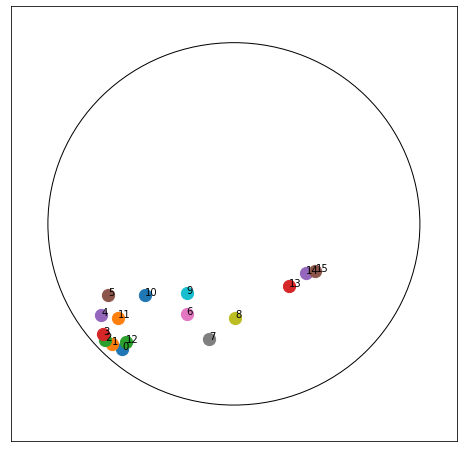

In [11]:
circle = visualization.PoincareDisk(point_type="ball")

fig, ax = plt.subplots(figsize=(8, 8))
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
circle.set_ax(ax)
circle.draw(ax=ax)
for i_embedding, embedding in enumerate(_MUTAG_emb):
    x = embedding[0]
    y = embedding[1]
    pt_id = i_embedding
    plt.scatter(x, y, s=150)
    ax.annotate(pt_id, (x, y))

In [12]:
_MUTAG_emb

array([[-0.60208189, -0.69268827],
       [-0.65361388, -0.66549976],
       [-0.69272179, -0.63996424],
       [-0.70446008, -0.60847059],
       [-0.71204745, -0.50516481],
       [-0.67518315, -0.39161953],
       [-0.25417041, -0.49792387],
       [-0.13229666, -0.63731565],
       [ 0.00550486, -0.51725293],
       [-0.25379635, -0.38199827],
       [-0.4760578 , -0.39215647],
       [-0.6247031 , -0.51711135],
       [-0.58223584, -0.65370046],
       [ 0.29734476, -0.3427209 ],
       [ 0.38840696, -0.27238315],
       [ 0.43825525, -0.25986918]])

In [13]:
_MUTAG_dist_mat = Poincare_dist.dist_pairwise(_MUTAG_emb)

In [14]:
_MUTAG_dist_mat

array([[0.        , 0.79325932, 1.45610619, 1.63803673, 1.93099129,
        2.09284735, 2.0460124 , 2.4650681 , 2.75930071, 2.18438935,
        1.82238615, 1.4053514 , 0.45196444, 3.4570334 , 3.68569541,
        3.81724   ],
       [0.79325932, 0.        , 0.76091146, 1.1035428 , 1.72138405,
        2.05666089, 2.3328836 , 2.80351949, 3.05125117, 2.42294741,
        1.96574044, 1.3329097 , 0.80831105, 3.71556115, 3.937042  ,
        4.06746101],
       [1.45610619, 0.76091146, 0.        , 0.54642087, 1.52684534,
        2.02895832, 2.5729804 , 3.0757792 , 3.28779078, 2.62472653,
        2.10460472, 1.34075248, 1.29319894, 3.92501402, 4.14073038,
        4.27018547],
       [1.63803673, 1.1035428 , 0.54642087, 0.        , 1.10556209,
        1.70279396, 2.42312884, 2.94498372, 3.13188004, 2.44806051,
        1.892344  , 1.08114302, 1.36682606, 3.74968386, 3.96132827,
        4.09007454],
       [1.93099129, 1.72138405, 1.52684534, 1.10556209, 0.        ,
        0.76449758, 1.94418764, 

In [15]:
_MUTAG_weights = _MUTAG_adj * _MUTAG_dist_mat

In [16]:
np.fill_diagonal(_MUTAG_weights, 1)

In [17]:
_MUTAG_weights[_MUTAG_weights == 0] = np.Inf

In [18]:
np.fill_diagonal(_MUTAG_weights, 0)

In [19]:
_MUTAG_weights

array([[0.        , 0.79325932,        inf,        inf,        inf,
               inf,        inf,        inf,        inf,        inf,
               inf,        inf, 0.45196444,        inf,        inf,
               inf],
       [0.79325932, 0.        , 0.76091146,        inf,        inf,
               inf,        inf,        inf,        inf,        inf,
               inf,        inf,        inf,        inf,        inf,
               inf],
       [       inf, 0.76091146, 0.        , 0.54642087,        inf,
               inf,        inf,        inf,        inf,        inf,
               inf,        inf,        inf,        inf,        inf,
               inf],
       [       inf,        inf, 0.54642087, 0.        , 1.10556209,
               inf,        inf,        inf,        inf,        inf,
               inf, 1.08114302,        inf,        inf,        inf,
               inf],
       [       inf,        inf,        inf, 1.10556209, 0.        ,
        0.76449758,        inf, 

In [28]:
VRPers = homology.VietorisRipsPersistence(metric="precomputed", homology_dimensions=(0, 1), max_edge_length=10)

In [35]:
_MUTAG_VR = VRPers.fit_transform(X=[_MUTAG_weights])

In [30]:
_MUTAG_VR

array([[[ 0.        ,  0.29230943,  0.        ],
        [ 0.        ,  0.42318964,  0.        ],
        [ 0.        ,  0.45196444,  0.        ],
        [ 0.        ,  0.54642087,  0.        ],
        [ 0.        ,  0.55545449,  0.        ],
        [ 0.        ,  0.58014542,  0.        ],
        [ 0.        ,  0.6259076 ,  0.        ],
        [ 0.        ,  0.75131744,  0.        ],
        [ 0.        ,  0.76091146,  0.        ],
        [ 0.        ,  0.76449758,  0.        ],
        [ 0.        ,  0.78877282,  0.        ],
        [ 0.        ,  0.79325932,  0.        ],
        [ 0.        ,  0.82010728,  0.        ],
        [ 0.        ,  0.86457133,  0.        ],
        [ 0.        ,  0.97265482,  0.        ],
        [ 1.52380645, 10.        ,  1.        ],
        [ 1.10556209, 10.        ,  1.        ],
        [ 1.08114302, 10.        ,  1.        ]]])

In [47]:
_MUTAG_VR_plot = VRPers.plot(_MUTAG_VR)

In [31]:
PersImg = diagrams.PersistenceImage()

In [41]:
_MUTAG_PI = PersImg.fit_transform(_MUTAG_VR)

In [42]:
_MUTAG_PI

array([[[[0.41077193, 0.18968683, 0.03744417, ..., 0.        ,
          0.        , 0.        ],
         [0.18968683, 0.08759384, 0.01729102, ..., 0.        ,
          0.        , 0.        ],
         [0.03744417, 0.01729102, 0.00341325, ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.011253  , 0.00519642, 0.00102577, ..., 0.        ,
          0.        , 0.        ],
         [0.05700609, 0.02632435, 0.00519642, ..., 0.        ,
          0.        , 0.        ],
         [0.12344822, 0.05700609, 0.011253  , ..., 0.        ,
          0.        , 0.        ]],

        [[0.41077193, 0.18968683, 0.03744417, ..., 0.        ,
          0.        , 0.        ],
         [0.18968683, 0.08759384, 0.01729102, ..., 0.        ,
          0.        , 0.        ],
         [0.03744417, 0.01729104, 0.00341384, ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.00324384,
          0.01643283, 0.0

In [43]:
PersImg.plot(_MUTAG_PI)